##**Regression with an Abalone Dataset**

The goal of this Kaggle competition is to predict the age of abalone from various physical measurements.

The evaluation metric for this competition is Root Mean Squared Logarithmic Error (**RMSLE**)


#**Problem Statement**

Abalone is a marine snail found in the cold coastal regions. Age is a vital characteristic that is used to determine its worth. However, determining the age of abalone is a highly involved process that is usually carried out in a laboratory.

 Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task.  Other measurements, which are easier to obtain, are used to predict the age.  Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.

#**Abalone Dataset Description**

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Abalone dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.



The original Abalone Dataset, From the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200). It has 10 attributes, as below mentioned:
1.   **id**
2.   **Sex** ---- M, F, and I (infant)
3.   **Length** ---- Longest shell measurement (units:mm)
4.   **Diameter** ---- perpendicular to length (units:mm)
5.   **Height** ---- with meat in shell (units:mm)
6.   **Whole_weight** ---- whole abalone (units:grams)
7.   **Whole weight.1** ---- Shucked_weight- weight of meat (units:grams)
8.   **Whole weight.2** ---- Viscera_weight- gut weight (after bleeding)(units:grams)
9.   **Shell_weight** ---- after being dried (units:grams)
10.  **Rings**---- +1.5 gives the age in years  -- Rings is the integer target


This Original Dataset can be downloaded from: [UCI](https://archive.ics.uci.edu/dataset/1/abalone)

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.6 MB/s eta 0:00:00


In [2]:
# Import Libraries

import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import skew
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PolynomialFeatures,StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import  KFold, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,StackingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_squared_log_error

import warnings
warnings.filterwarnings("ignore")

##Fetch Original Data from UCI

In [3]:
#Install the ucimlrepo package
!pip install ucimlrepo

#Original Dataset from UCI ML repository

from ucimlrepo import fetch_ucirepo

# fetch dataset
abalone = fetch_ucirepo(id=1)

# data (as pandas dataframes)
X_original = abalone.data.features
y_original = abalone.data.targets

# metadata
print(abalone.metadata)

# variable information
print(abalone.variables)

{'uci_id': 1, 'name': 'Abalone', 'repository_url': 'https://archive.ics.uci.edu/dataset/1/abalone', 'data_url': 'https://archive.ics.uci.edu/static/public/1/data.csv', 'abstract': 'Predict the age of abalone from physical measurements', 'area': 'Biology', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular'], 'num_instances': 4177, 'num_features': 8, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Rings'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C55C7W', 'creators': ['Warwick Nash', 'Tracy Sellers', 'Simon Talbot', 'Andrew Cawthorn', 'Wes Ford'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- 

In [4]:
#To merge these two datasets effectively, some features need to be renamed to ensure consistency
column_mapping = {'Shucked_weight': 'Whole weight.1', 'Viscera_weight': 'Whole weight.2', 'Shell_weight':'Shell weight', 'Whole_weight':'Whole weight'}
X_original.rename(columns=column_mapping, inplace=True)

##Fetch Data from Kaggle Competition

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c playground-series-s4e4 -p /content
!unzip -q playground-series-s4e4.zip -d /content/dataset

  0% 0.00/2.41M [00:00<?, ?B/s]
100% 2.41M/2.41M [00:00<00:00, 135MB/s]


In [6]:
#Loading the Dataset
train_data = pd.read_csv('/content/dataset/train.csv')
test_data = pd.read_csv('/content/dataset/test.csv')

#check the head of dataset
train_data.head(5)

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [7]:
train_data = train_data.drop(['id'] , axis=1)

print('Shape of train data is : ' , train_data.shape)
print('train data columns: ' , train_data.columns)

Shape of train data is :  (90615, 9)
train data columns:  Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'Rings'],
      dtype='object')


##Merge kaggle and UCI dataset

In [8]:
original_data = X_original.copy()
original_data['Rings'] = y_original

train_data = pd.concat([train_data, original_data], ignore_index=True)
print('Shape of train data is : ' , train_data.shape)

Shape of train data is :  (94792, 9)


In [9]:
# Set features and target
X_train = train_data.drop('Rings', axis=1)
y_train = train_data['Rings']

In [10]:
duplicated_rows = train_data.duplicated()
sum(duplicated_rows)

0

#**Exploratory Data Analysis (EDA)**


In [11]:
#some information about the attributes(datatypes & null values)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94792 entries, 0 to 94791
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             94792 non-null  object 
 1   Length          94792 non-null  float64
 2   Diameter        94792 non-null  float64
 3   Height          94792 non-null  float64
 4   Whole weight    94792 non-null  float64
 5   Whole weight.1  94792 non-null  float64
 6   Whole weight.2  94792 non-null  float64
 7   Shell weight    94792 non-null  float64
 8   Rings           94792 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 6.5+ MB


In [12]:
#Check statistical information of numerical values

numerical_features = train_data.select_dtypes(include=[np.number])
train_data.describe(include=[np.number])

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,94792.000000,94792.000000,94792.000000,94792.000000,94792.000000,94792.000000,94792.000000,94792.000000
mean,0.517402,0.401952,0.135643,0.790785,0.341597,0.169914,0.226468,9.707233
std,0.118308,0.098088,0.038193,0.459231,0.205267,0.101334,0.130639,3.178704
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.445000,0.345000,0.110000,0.419500,0.177500,0.086500,0.120000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,0.600000,0.470000,0.160000,1.072500,0.464500,0.233000,0.305000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [ ]:
#distribution of numerical features

fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(22, 5))
index = 0
axs = axs.flatten()
for k,v in numerical_features.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=3, w_pad=3, h_pad=8.0)

In [13]:
#Check statistical information of categorical values

categorial_features = train_data.select_dtypes(include=object)
X_train.describe(include=object)

,Sex
count,94792
unique,3
top,I
freq,34435


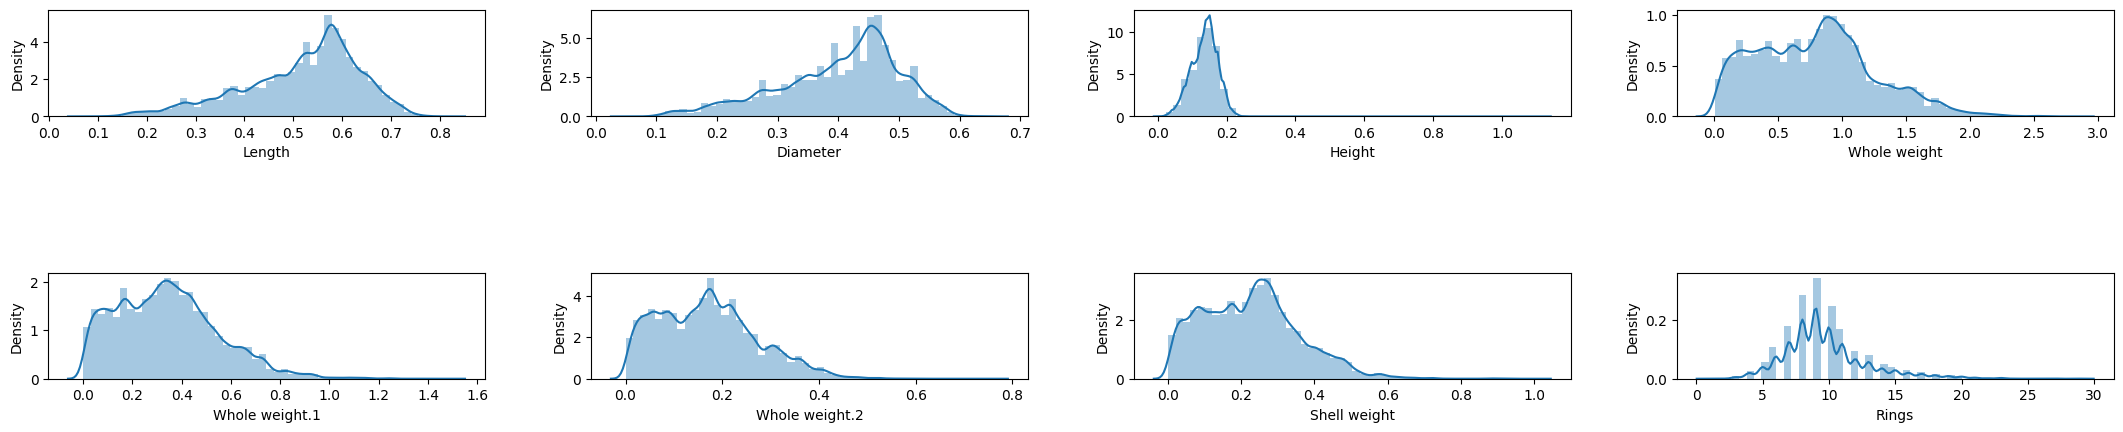

In [14]:
#distribution of numerical features

fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(22, 5))
index = 0
axs = axs.flatten()
for k,v in numerical_features.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=3, w_pad=3, h_pad=8.0)

In [15]:
skew_limit = 0.5

skew_features = numerical_features.skew()

# Showing the skewed columns
skew_cols = (skew_features
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {}'.format(skew_limit)))
skew_cols

,Skew
Rings,1.200004
Whole weight.1,0.601075
Diameter,-0.690925
Length,-0.727373


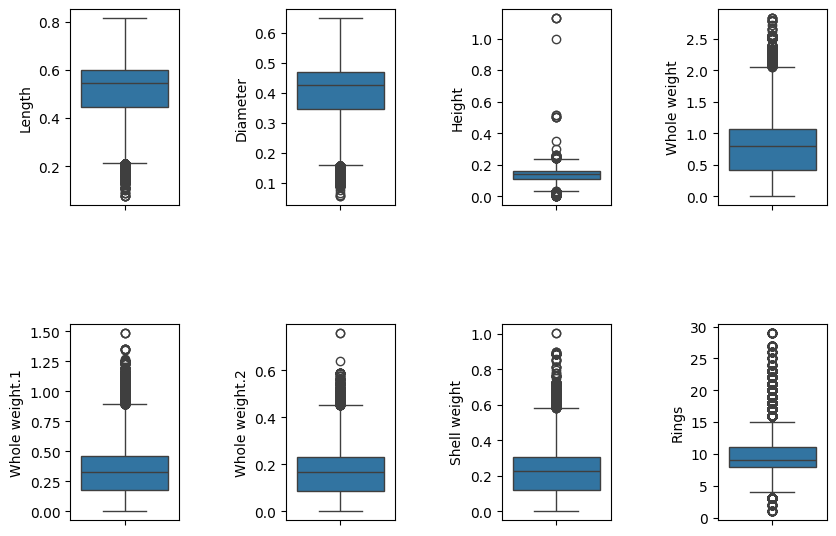

In [16]:
#Boxplot
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(9, 6))
index = 0
axs = axs.flatten()
for k,v in train_data.select_dtypes(include=[np.number]).items():
    sns.boxplot(y=k, data=train_data, ax=axs[index])
    index += 1
plt.tight_layout(pad=3, w_pad=4, h_pad=8.0)

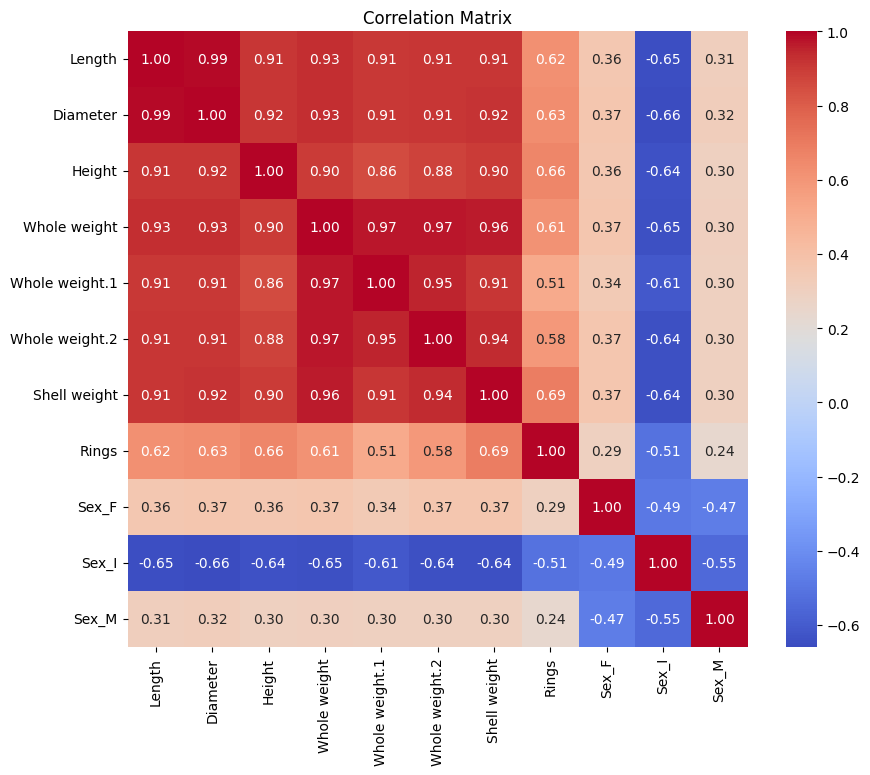

In [17]:
#get_dummies
cols = ['Sex']
train_data = pd.get_dummies(train_data, columns= cols , dtype= float)

# Compute the correlation matrix
correlation_matrix = train_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

#**Data Preprocessing**

##**Target transformation**
as you see in EDA, target feature 'Rings' is rigth skewed and imbalanced.

In [18]:
num_unique_rings = train_data['Rings'].value_counts()
num_unique_rings

Rings
9     18154
8     15067
10    13098
7      9399
11     8894
6      5670
12     4986
13     4277
5      2977
14     2633
15     2175
16     1506
4      1459
17     1233
18      890
19      671
20      533
3       401
21      269
23      189
22      114
27       43
24       31
2        30
1        26
29       25
25       23
26       19
Name: count, dtype: int64

In [19]:
y_train = y_train.apply(np.log1p)
y_train

0        2.484907
1        2.484907
2        1.945910
3        2.397895
4        2.302585
           ...   
94787    2.484907
94788    2.397895
94789    2.302585
94790    2.397895
94791    2.564949
Name: Rings, Length: 94792, dtype: float64

##**Outlier Handling**

In [20]:
X_numerical_features = X_train.select_dtypes(include=[np.number])

# Define a function to find outliers based on IQR
def find_outliers(df):
    outliers = {}
    for col in df.columns:
        v = df[col]
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 2.2 * iqr
        upper_bound = q3 + 2.2 * iqr
        outliers_count = ((v < lower_bound) | (v > upper_bound)).sum()
        perc = outliers_count * 100.0 / len(df)
        outliers[col] = (perc, outliers_count)
        print(f"Column {col} outliers = {perc:.2f}% ({outliers_count} out of {len(df)})")
    return outliers

# Find outliers in the DataFrame
outliers = find_outliers(X_numerical_features)

Column Length outliers = 0.01% (10 out of 94792)
Column Diameter outliers = 0.00% (4 out of 94792)
Column Height outliers = 0.01% (12 out of 94792)
Column Whole weight outliers = 0.05% (44 out of 94792)
Column Whole weight.1 outliers = 0.20% (193 out of 94792)
Column Whole weight.2 outliers = 0.03% (31 out of 94792)
Column Shell weight outliers = 0.11% (108 out of 94792)


In [21]:
class OutlierBoundaryImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        Q1 = np.percentile(X, 25, axis=0)
        Q3 = np.percentile(X, 75, axis=0)
        IQR = Q3 - Q1
        self.lower_bound = Q1 - 1.5 * IQR
        self.upper_bound = Q3 + 1.5 * IQR
        return self

    def transform(self, X):
        X_outlier_imputed = np.where(X < self.lower_bound, self.lower_bound, X)
        X_outlier_imputed = np.where(X_outlier_imputed > self.upper_bound, self.upper_bound, X_outlier_imputed)
        return X_outlier_imputed

##**impute zero values in Height column**

In [22]:
zero_values = (X_train['Height'] == 0)
print ('Number of zero values: {}'.format(sum(zero_values)))

Number of zero values: 8


In [23]:
# Find the column most correlated with "Height"
correlation_matrix = X_train.select_dtypes(include=[np.number]).corr()
most_correlated = correlation_matrix['Height'].sort_values(ascending=False).index[1]
correlation_value = correlation_matrix['Height'][most_correlated]
print(f"The column most correlated with 'Height' is '{most_correlated}' with a correlation value of {correlation_value:.2f}")

The column most correlated with 'Height' is 'Diameter' with a correlation value of 0.92


In [24]:
# Group by 'Diameter' and calculate the median 'Height' within each group
median_height_by_diameter = X_train.groupby('Diameter')['Height'].median()

# Create a function to impute zero values with median 'Height' based on 'Diameter'
def impute_height(row):
    if row['Height'] == 0:
        diameter_median_height = median_height_by_diameter.get(row['Diameter'])
        if diameter_median_height is not None:
            return diameter_median_height
    return row['Height']

# Apply the function to impute missing 'Height' values
X_train['Height'] = X_train.apply(impute_height, axis=1)

In [25]:
zero_values = (X_train['Height'] == 0)
print ('Number of zero values: {} \n'.format(sum(zero_values)))

Number of zero values: 0 



##**Categorical Feature Encoding**

In [26]:
#get_dummies
cols = ['Sex']
X_train = pd.get_dummies(X_train, columns= cols , dtype= float)
X_train.head(2)

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Sex_F,Sex_I,Sex_M
0,0.55,0.43,0.150,0.7715,0.3285,0.1465,0.24,1.0,0.0,0.0
1,0.63,0.49,0.145,1.1300,0.4580,0.2765,0.32,1.0,0.0,0.0


##**Feature Engineering:**

Feature engineering involves creating new features from existing ones to enhance the predictive power of a model.

In [27]:
# Feature Engineering

def Feature_Engineering(data):

  #  Proportion of Shucked Weight to Whole Weight
  data['WholeW1_to_WholeW_Proportion'] = data['Whole weight.1'] / data['Whole weight']

  return data

X_train = Feature_Engineering(X_train)

In [28]:
Xnumfeatures = X_train.drop(columns=['Sex_F', 'Sex_I', 'Sex_M'], axis=1)
skew_features = Xnumfeatures.skew()

skew_limit = 0.75
# Showing the skewed columns
skew_cols = (skew_features
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {}'.format(skew_limit)))
skew_cols

,Skew
WholeW1_to_WholeW_Proportion,25.287583


In [29]:
#perrform the skew transformation:
for col in skew_cols.index.values:
    X_train[col] = X_train[col].apply(np.log1p)

##Evaluation Function

In [30]:
cv_method = KFold   # StratifiedKFold
n_splits = 5
# scaler = MinMaxScaler()
scaler = StandardScaler()

def evaluation(model_name, pipeline_model, X, y):

    def transform_and_score(scorer_func):
        def wrapper(y_true, y_pred):
            y_true, y_pred = np.expm1(y_true), np.expm1(y_pred)
            return scorer_func(y_true, y_pred)
        return wrapper

    rmsle = transform_and_score(lambda y_true, y_pred: np.sqrt(mean_squared_log_error(y_true, y_pred)))
    r2 = transform_and_score(r2_score)
    msle = transform_and_score(mean_squared_log_error)
    rmse = transform_and_score(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))

    scoring = {
        'rmsle': make_scorer(rmsle, greater_is_better=False),
        'r2': make_scorer(r2),
        'rmse': make_scorer(rmse, greater_is_better=False),
        'msle': make_scorer(msle, greater_is_better=False)
    }

    cv = StratifiedKFold(n_splits=n_splits, shuffle=False) if cv_method == 'StratifiedKFold' else KFold(n_splits=n_splits, shuffle=True, random_state=42)

    scores = cross_validate(pipeline_model, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=True, return_estimator=True)

    def print_scores(score_type):
        print(f"\n===> {score_type} Scores:")
        for metric in ['rmsle', 'r2', 'rmse', 'msle']:
            mean = np.abs(scores[f'{score_type}_{metric}']).mean()
            std = np.abs(scores[f'{score_type}_{metric}']).std()
            print(f"The average of {metric.upper()} is : {mean:.5f} (+/- {std:.2f})")

    print(f'\n{model_name} with {cv_method}, k={n_splits} report:')
    print_scores('train')
    print_scores('test')

##hyperparameter_tuning

In [31]:
def rmsle(y_true, y_pred):
    y_true, y_pred = np.expm1(y_true), np.expm1(y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def hyperparameter_tuning(model_name, X_train, y_train):
    scaler = StandardScaler()

    model_configs = {
        'LGBM_Regressor': {
            'model': LGBMRegressor(force_col_wise=True, num_leaves=100, random_state=42),
            'params': {
                'n_estimators': [1460],    #[2900, 3000],
                'learning_rate': [0.0094], #[0.01, 0.015],
                'max_depth': [20],         #[6],
                'reg_alpha': [0.32],       #[0.8],
                'reg_lambda': [6.13],      #[0.5],
                'num_leaves': [165],
                'subsample_freq': [1],
                'min_child_samples': [25],
                'subsample': [0.81],
                'colsample_bytree': [0.58],
                'min_child_weight': [0.37],
            }
        },
        'XGBoost_Regressor': {
            'model': XGBRegressor(random_state=42),
            'params': {
                'n_estimators': [1400, 1500],
                'learning_rate': [0.022, 0.0218],
                'max_depth': [5]
            }
        },
        'CatBoostRegressor': {
            'model': CatBoostRegressor(random_state=42),
            'params': {
                'n_estimators': [1000],    #[1000, 1500],
                'learning_rate': [0.1],    #[0.01, 0.02, 0.05, 0.1],
                'depth': [15],             #[8, 15],
                'l2_leaf_reg': [8.37],     #[2, 10],
                'max_bin': [464],
                'eval_metric': ['RMSE'],
                'min_data_in_leaf': [78],
                'loss_function': ['RMSE'],
                'grow_policy': ['Lossguide'],
                'subsample': [0.84],
                'random_strength': [3.3]
            }
        },
        'GradientBoostingRegressor': {
            'model': GradientBoostingRegressor(random_state=42),
            'params': {
                'n_estimators': [1520],   #[100, 200],
                'learning_rate': [0.022], #[0.05, 0.1],
                'max_depth': [7],         #[3, 7],
                'min_samples_leaf': [2],
                'min_samples_split': [5],
                'subsample': [0.84]
            }
        }
    }


    if model_name not in model_configs:
        raise ValueError(f"Model {model_name} not supported")

    model_config = model_configs[model_name]
    pipeline = Pipeline([
        ('outlier_imputer', OutlierBoundaryImputer()),
        ('scaler', scaler),
        ('model', model_config['model'])
    ])

    param_grid = {f'model__{k}': v for k, v in model_config['params'].items()}

    rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring=rmsle_scorer, verbose=4, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print('\nBest parameters:', grid_search.best_params_)
    print("Best score:", f"{grid_search.best_score_:.5f}")

    best_params = {k.split('__')[1]: v for k, v in grid_search.best_params_.items()}
    return best_params, grid_search.best_estimator_


##**Model Selection**

##**XGBRegressor**

In [32]:
model_name_xgb = 'XGBoost_Regressor'
best_params_xgb, best_model_xgb = hyperparameter_tuning(model_name_xgb, X_train, y_train)
print(best_params_xgb)
evaluation(model_name_xgb, best_model_xgb, X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best parameters: {'model__learning_rate': 0.0218, 'model__max_depth': 5, 'model__n_estimators': 1500}
Best score: -0.14977
{'learning_rate': 0.0218, 'max_depth': 5, 'n_estimators': 1500}

XGBoost_Regressor with <class 'sklearn.model_selection._split.KFold'>, k=5 report:

===> train Scores:
The average of RMSLE is : 0.14024 (+/- 0.00)
The average of R2 is : 0.70835 (+/- 0.00)
The average of RMSE is : 1.71662 (+/- 0.00)
The average of MSLE is : 0.01967 (+/- 0.00)

===> test Scores:
The average of RMSLE is : 0.14977 (+/- 0.00)
The average of R2 is : 0.66103 (+/- 0.00)
The average of RMSE is : 1.85059 (+/- 0.01)
The average of MSLE is : 0.02243 (+/- 0.00)


##**GradientBoostingRegressor**

In [33]:
model_name_gb = 'GradientBoostingRegressor'
best_params_gb, best_model_gb = hyperparameter_tuning(model_name_gb, X_train, y_train)
print(best_params_gb)
evaluation(model_name_gb, best_model_gb, X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters: {'model__learning_rate': 0.022, 'model__max_depth': 7, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 1520, 'model__subsample': 0.84}
Best score: -0.14872
{'learning_rate': 0.022, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1520, 'subsample': 0.84}

GradientBoostingRegressor with <class 'sklearn.model_selection._split.KFold'>, k=5 report:

===> train Scores:
The average of RMSLE is : 0.12398 (+/- 0.00)
The average of R2 is : 0.77655 (+/- 0.00)
The average of RMSE is : 1.50258 (+/- 0.01)
The average of MSLE is : 0.01537 (+/- 0.00)

===> test Scores:
The average of RMSLE is : 0.14872 (+/- 0.00)
The average of R2 is : 0.66851 (+/- 0.00)
The average of RMSE is : 1.83004 (+/- 0.01)
The average of MSLE is : 0.02212 (+/- 0.00)


##**LightGBM (LGBMRegressor):**

In [34]:
model_name_lgbm = 'LGBM_Regressor'
best_params_lgbm, best_model_lgbm = hyperparameter_tuning(model_name_lgbm, X_train, y_train)
print(best_params_lgbm)
evaluation(model_name_lgbm, best_model_lgbm, X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Total Bins 1546
[LightGBM] [Info] Number of data points in the train set: 94792, number of used features: 11
[LightGBM] [Info] Start training from score 2.329925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Best parameters: {'model__colsample_bytree': 0.58, 'model__learning_rate': 0.0094, 'model__max_depth': 20, 'model__min_child_samples': 25, 'model__min_child_weight': 0.37, 'model__n_estimators': 1460, 'model__num_leaves': 165, 'model__reg_alpha': 0.32, 'model__reg_lambda': 6.13, 'model__subsample': 0.81, 'mod

##**CatBoost (CatBoostRegressor)**

In [35]:
model_name_cat = 'CatBoostRegressor'
best_params_cat, best_model_cat = hyperparameter_tuning(model_name_cat, X_train, y_train)
print(best_params_cat)
evaluation(model_name_cat, best_model_cat, X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 0.2677463	total: 108ms	remaining: 1m 47s
1:	learn: 0.2522685	total: 199ms	remaining: 1m 39s
2:	learn: 0.2386635	total: 262ms	remaining: 1m 27s
3:	learn: 0.2265708	total: 366ms	remaining: 1m 31s
4:	learn: 0.2160439	total: 472ms	remaining: 1m 33s
5:	learn: 0.2071414	total: 582ms	remaining: 1m 36s
6:	learn: 0.1999172	total: 682ms	remaining: 1m 36s
7:	learn: 0.1933090	total: 795ms	remaining: 1m 38s
8:	learn: 0.1878175	total: 890ms	remaining: 1m 37s
9:	learn: 0.1830329	total: 992ms	remaining: 1m 38s
10:	learn: 0.1789008	total: 1.06s	remaining: 1m 35s
11:	learn: 0.1753961	total: 1.16s	remaining: 1m 35s
12:	learn: 0.1721800	total: 1.23s	remaining: 1m 33s
13:	learn: 0.1695309	total: 1.31s	remaining: 1m 32s
14:	learn: 0.1673607	total: 1.43s	remaining: 1m 33s
15:	learn: 0.1656470	total: 1.49s	remaining: 1m 31s
16:	learn: 0.1639080	total: 1.61s	remaining: 1m 33s
17:	learn: 0.1625496	total: 1.69s	remaining: 1m 32s
18:	learn: 0.16

##**VotingRegressor**

In [37]:
estimators = [('catboost', best_model_cat), ('gb',best_model_gb), ('lgbm', best_model_lgbm)]
weights=[0.35, 0.35, 0.3]
# weights=[0.38, 0.29, 0.33]
voting_regressor = VotingRegressor(estimators,weights=weights)

pipeline_model = Pipeline(steps=[('outlier_imputer', OutlierBoundaryImputer()),
                                 ('scaler', scaler), ('model', voting_regressor)])

evaluation('VotingRegressor', pipeline_model, X_train, y_train)


VotingRegressor with <class 'sklearn.model_selection._split.KFold'>, k=5 report:

===> train Scores:
The average of RMSLE is : 0.12771 (+/- 0.00)
The average of R2 is : 0.76246 (+/- 0.00)
The average of RMSE is : 1.54923 (+/- 0.00)
The average of MSLE is : 0.01631 (+/- 0.00)

===> test Scores:
The average of RMSLE is : 0.14810 (+/- 0.00)
The average of R2 is : 0.67066 (+/- 0.00)
The average of RMSE is : 1.82409 (+/- 0.01)
The average of MSLE is : 0.02193 (+/- 0.00)


##**Train**

In [38]:
# Fit the pipeline on the entire training data
pipeline_model = pipeline_model.fit(X_train, y_train)
y_pred_train = pipeline_model.predict(X_train)

y_true = np.expm1(y_train)
y_pred = np.expm1(y_pred_train)
# Calculate the evaluation metrics on the entire training data
train_rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
train_r2 = r2_score(y_true, y_pred)

# Print the evaluation metrics on the train data
print("Train RMSLE:", train_rmsle)
print("Train R2 score:", train_r2)

0:	learn: 0.2677463	total: 51.4ms	remaining: 51.4s
1:	learn: 0.2522685	total: 103ms	remaining: 51.1s
2:	learn: 0.2386635	total: 146ms	remaining: 48.5s
3:	learn: 0.2265708	total: 190ms	remaining: 47.4s
4:	learn: 0.2160439	total: 235ms	remaining: 46.7s
5:	learn: 0.2071414	total: 282ms	remaining: 46.7s
6:	learn: 0.1999172	total: 327ms	remaining: 46.3s
7:	learn: 0.1933090	total: 373ms	remaining: 46.2s
8:	learn: 0.1878175	total: 420ms	remaining: 46.3s
9:	learn: 0.1830329	total: 471ms	remaining: 46.7s
10:	learn: 0.1789008	total: 522ms	remaining: 46.9s
11:	learn: 0.1753961	total: 572ms	remaining: 47.1s
12:	learn: 0.1721800	total: 618ms	remaining: 46.9s
13:	learn: 0.1695309	total: 670ms	remaining: 47.2s
14:	learn: 0.1673607	total: 718ms	remaining: 47.2s
15:	learn: 0.1656470	total: 767ms	remaining: 47.2s
16:	learn: 0.1639080	total: 824ms	remaining: 47.6s
17:	learn: 0.1625496	total: 871ms	remaining: 47.5s
18:	learn: 0.1614292	total: 924ms	remaining: 47.7s
19:	learn: 0.1603912	total: 979ms	remain

##**Test**

In [39]:
test_data = pd.read_csv('/content/dataset/test.csv')

print('Shape of test data is : ' , test_data.shape)
print('test data columns: ' , test_data.columns)

Shape of test data is :  (60411, 9)
test data columns:  Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
       'Whole weight.1', 'Whole weight.2', 'Shell weight'],
      dtype='object')


##Transform preprocessing on test data

In [40]:
test_ids = test_data['id']
test_data = test_data.drop('id', axis=1)

In [41]:
# Zero imputation

zero_values = (test_data['Height'] == 0)
if zero_values.any():
  print ('Number of zero values: {}'.format(sum(zero_values)))
  # Apply the function to impute missing 'Height' values
  test_data['Height'] = test_data.apply(impute_height, axis=1)
else:
   print("There are no zero values in the 'Height' column.")

Number of zero values: 2


In [42]:
# feature engineering

test_data = Feature_Engineering(test_data)

In [43]:
#perrform the skew transformation:
for col in skew_cols.index.values:
    test_data[col] = test_data[col].apply(np.log1p)

In [44]:
#Encoding categorical feature

cols = ['Sex']
test_data = pd.get_dummies(test_data, columns= cols , dtype= float)
# Align test data with training data columns
test_data = test_data.reindex(columns=X_train.columns, fill_value=0)
test_data.head(2)

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Sex_F,Sex_I,Sex_M,WholeW1_to_WholeW_Proportion
0,0.645,0.475,0.155,1.238,0.6185,0.3125,0.3005,0.0,0.0,1.0,0.405196
1,0.580,0.460,0.160,0.983,0.4785,0.2195,0.2750,0.0,0.0,1.0,0.396609


In [45]:
# Predict the test data
y_pred_test = pipeline_model.predict(test_data)
y_pred_test = np.expm1(y_pred_test)
y_pred_test

array([ 9.95319585,  9.72862188,  9.89955203, ..., 13.13894543,
       13.47283972,  8.44574532])

In [46]:
# Create a DataFrame with id column and predictions
submission_df = pd.DataFrame({'id': test_ids, 'Rings': y_pred_test})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)